## Hyperparameter tuning

note that all the hyperparameter tuning was done on GPUs supplied by GOOGLE COLAB. This is a proxy script that runs the equivalent hyperparameter tuning in jupyter notebook.

### Loading datasets and preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pickle
import talos


Using TensorFlow backend.


In [2]:
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k

n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 15.79it/s]


### Setup Keras model and training

In [3]:
# use data for zone 1.
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [4]:
# helper function to read data.
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

def create_model(train_X, train_Y, window_size = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(5,input_shape = (1, window_size), ))
    vanilla_rnn.add(Dense(1))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

In [7]:
window_size = 50
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

### Use Talos to perform tuning

In [8]:
def model_talos(train_X, train_Y, val_X, val_Y, params):
    vanilla_rnn = Sequential()
    
    for i in range(max(params['layers']-1, 0)):
        vanilla_rnn.add(LSTM(params['first_lstm'], return_sequences=True))

    vanilla_rnn.add(LSTM(params['first_lstm'],input_shape = (1, window_size), activation='tanh', 
                         recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', 
                         recurrent_initializer='orthogonal', bias_initializer='zeros'))
    
    vanilla_rnn.add(Dense(1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    
    vanilla_rnn.compile(params['optimizer'], loss=params['loss'])
    
    history = vanilla_rnn.fit(train_X, train_Y, epochs = params['epochs'], batch_size = params['batch_size'], 
                              verbose = 0,  validation_data=[val_X, val_Y])
    
    return history, vanilla_rnn

In [10]:
# window size trained seperately
p = {'optimizer': ['adam', 'sgd', 'rmsprop'],
     'loss': ['mse'],
     'batch_size': [32, 128, 1024],
     'epochs': [5, 10, 20],
     'layers' : [1, 2],
     'first_lstm' : [4, 8, 16, 32]}

scan_object = talos.Scan(train_X, train_Y, model=model_talos, params=p, fraction_limit=0.01, val_split=0.15, experiment_name='hyperparameter_tuning_results')

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.80s/it]


### Plotting hyperparameter tuning results

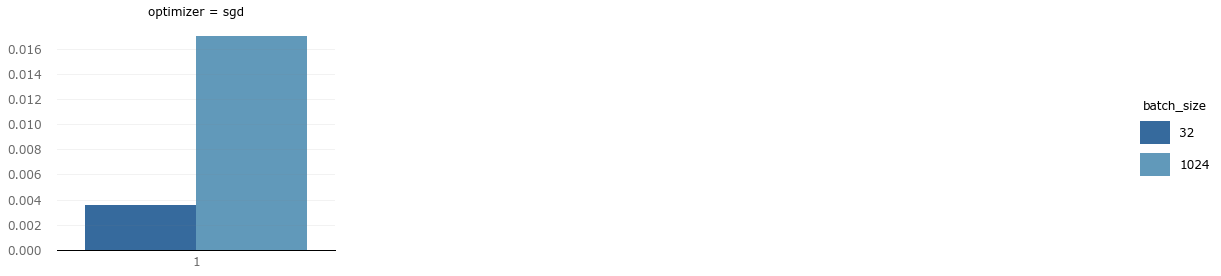

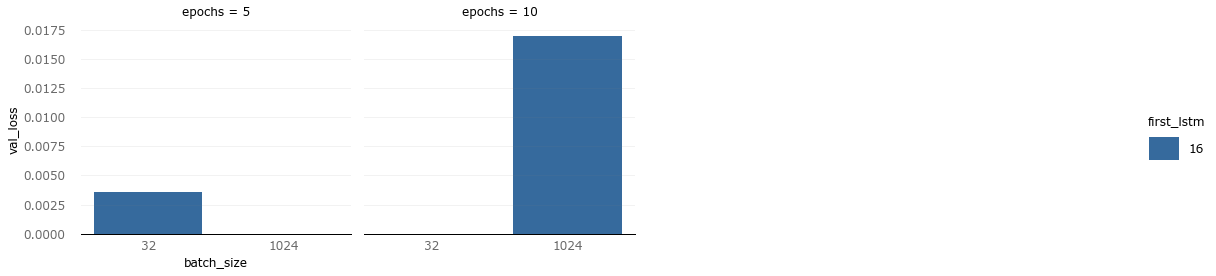

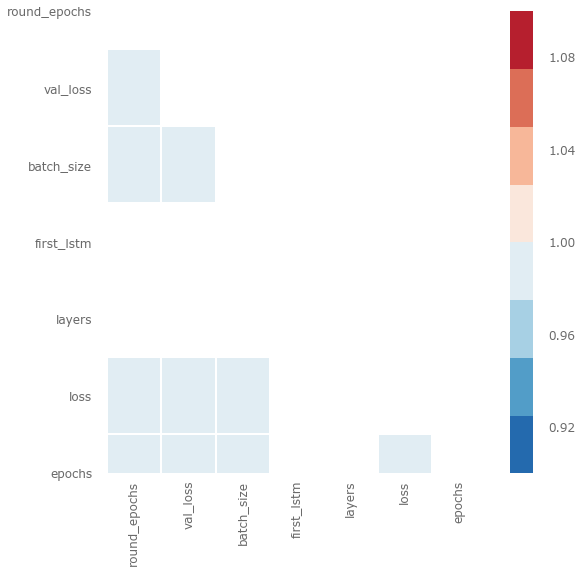

In [13]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

# use Scan object as input
analyze_object = talos.Analyze(scan_object)

# access the dataframe with the results
analyze_object.data

# four dimensional bar grid
analyze_object.plot_bars('layers', 'val_loss', 'batch_size', 'optimizer')

# four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_loss', 'first_lstm', 'epochs')

# heatmap correlation
analyze_object.plot_corr('val_loss', [])